# Generative Adversarial Networks (GANs) on MNIST Dataset: From Scratch to Synthesis

## Introduction

Welcome to this deep dive into Generative Adversarial Networks (GANs). In this notebook, we aim to implement GANs from scratch, using the MNIST dataset as our playground. While GANs have a myriad of applications, from art creation to data augmentation, our primary focus will be on understanding the architecture and mechanisms underlying these fascinating models.

### What are GANs?

![GANs](./assets/GANs.png)

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. They are a type of generative model, a model that learns to generate new data instances that resemble the training data. GANs are composed of two neural networks, a generator and a discriminator, that compete against each other in a zero-sum game framework. The generator tries to fool the discriminator by generating fake data instances, while the discriminator tries to distinguish between the real and fake data instances. The generator is trained to fool the discriminator, and the discriminator is trained to not be fooled by the generator. This competition between the two networks is what gives GANs their name.

### Why GANs?

GANs are one of the most exciting advancements in the field of machine learning and artificial intelligence in the last decade. They provide a framework for training generative models that can create data instances statistically similar to some input data. In other words, they allow us to generate new data that is similar but not identical to the data we have.

### What Will We Learn?

- Fundamentals of Generative Adversarial Networks
- Custom Data Processing on the MNIST dataset
- Creating Models from Scratch
- Implementing Cost Functions
- Training the GAN
- Evaluating the Results

## Dataset Used

We'll use the MNIST dataset, comprising hand-written digits, to train our GAN model. This dataset is commonly used for practicing various machine learning algorithms and is readily available through PyTorch's torchvision package.

## Authors

- [Joaquin Vigna](https://github.com/BRJoaquin)

> **Note**: This notebook is also a part of an academic assignment; however, it is designed to be a comprehensive guide. Feel free to reach out if you have suggestions for improvements or find errors.

## References

- Original GAN Paper: [Generative Adversarial Nets](https://arxiv.org/abs/1406.2661)
- MNIST Dataset: [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist/)

## Imports

In this notebook we are going to use conda to install the required packages. 
You can find the instructions to install conda [here](https://docs.conda.io/projects/conda/en/latest/user-guide/install/), and the dependencies are listed in the `environment.yml` file.

In [1]:
# PyTorch is an open-source machine learning library used for a variety of tasks,
# but primarily for training deep neural networks.
import torch

# nn is a sub-module in PyTorch that contains useful classes and functions to build neural networks.
import torch.nn as nn

# F is a sub-module in PyTorch that contains useful functions for building neural networks.
import torch.nn.functional as F

# DataLoader is a PyTorch utility for loading and batching data efficiently.
from torch.utils.data import DataLoader, Subset

# torchvision contains various utilities, pre-trained models, and datasets specifically
# geared towards computer vision tasks.
import torchvision

# datasets are a set of common datasets used for computer vision tasks.
# transforms are a set of common image transformations that are often required when
# working with image data.
from torchvision import datasets, transforms

# ImageFolder is a utility for loading images directly from a directory structure where
# each sub-directory represents a different class.
from torchvision.datasets import ImageFolder

# random_split is a utility function to randomly split a dataset into non-overlapping
# new datasets of given lengths.
from torch.utils.data import random_split

# SummaryWriter is a PyTorch utility for logging information to be displayed in TensorBoard.
from torch.utils.tensorboard import SummaryWriter

# summary is a PyTorch utility for displaying the summary of a PyTorch model.
from torchinfo import summary

# tqdm is a Python library that adds a progress bar to an iterable object.
from tqdm import tqdm

# Matplotlib is a plotting library that is useful for visualizing data, plotting graphs, etc.
import matplotlib.pyplot as plt

# NumPy is a library for numerical operations and is especially useful for array and
# matrix computations.
import numpy as np

# PIL is a library for image processing.
from PIL import Image

# os is a Python module that provides a portable way of using operating system dependent
import os

# time is a module that provides various time-related functions.
import time

# random is a module that implements pseudo-random number generators for various distributions.
import random

# accuracy_score computes the accuracy classification score.
# confusion_matrix computes confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

# itertools is a module that provides various functions that work on iterators to produce
from itertools import product

# math is a module that provides access to the mathematical functions.
import math

# Counter is a dictionary subclass for counting hashable objects.
from collections import Counter

## Checking CUDA Availability

In deep learning projects, it's common to leverage the power of GPUs for computation. CUDA is a parallel computing platform that allows us to use the GPU for these intensive calculations. The following code snippet checks if CUDA is available on the machine. If CUDA is available, it sets the device to "cuda"; otherwise, it falls back to using the CPU.

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


## Setting the Seed

Setting the seed ensures that the results are reproducible. This is important for debugging and testing purposes.

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Exploration: Understanding the MNIST Dataset

Before diving into the complexities of Generative Adversarial Networks, it's essential to have a solid understanding of the dataset we'll be working with. The MNIST dataset contains 28x28 grayscale images of handwritten digits (0 through 9).

### Objectives

1. Load the MNIST dataset from PyTorch's `torchvision` package.
2. Visualize some sample images from the dataset.
3. Examine the distribution of different classes (digits 0-9) in the dataset.
4. Understand basic statistics and properties of the dataset like mean, standard deviation, etc.

### Loading the Data

The MNIST dataset can be easily loaded using the `torchvision.datasets` package from PyTorch. It provides an easy-to-use API for downloading and accessing the dataset.

In [4]:
def get_data_loader(transform, batch_size=32):
    # Download and load the MNIST data
    train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    combined_data = torch.utils.data.ConcatDataset([train_data, test_data])
    # DataLoader allows us to batch and shuffle the data
    train_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)
    return train_loader

### Sample Images

Visualizing data samples is a powerful way to get a sense of what you're working with. This sub-section will display some example images from the MNIST dataset.

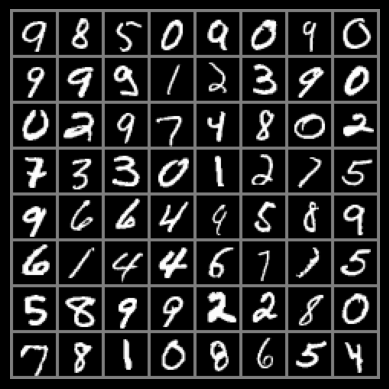

Labels:
9 8 5 0 9 0 9 0
9 9 9 1 2 3 9 0
0 2 9 7 4 8 0 2
7 3 3 0 1 2 7 5
9 6 6 4 9 5 8 9
6 1 4 4 6 7 1 5
5 8 9 9 2 2 8 0
7 8 1 0 8 6 5 4


In [5]:
number_of_real_samples = 64


# Function to display an image grid
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


trainform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_loader = get_data_loader(trainform, batch_size=number_of_real_samples)
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid
imshow(torchvision.utils.make_grid(images[:number_of_real_samples]))


# Function to print labels in rows
def print_labels_in_rows(labels, labels_per_row=8):
    for i in range(0, len(labels), labels_per_row):
        print(
            " ".join(
                str(labels[j].item())
                for j in range(i, min(i + labels_per_row, len(labels)))
            )
        )


# Print the labels in rows
print("Labels:")
print_labels_in_rows(labels, labels_per_row=8)

### Class Distribution

Understanding the distribution of different classes within the dataset is crucial. This can help us assess whether the dataset is balanced or skewed, which in turn informs model design and evaluation metrics.

Class Distribution: {3: 7141, 8: 6825, 7: 7293, 4: 6824, 2: 6990, 9: 6958, 0: 6903, 6: 6876, 1: 7877, 5: 6313}


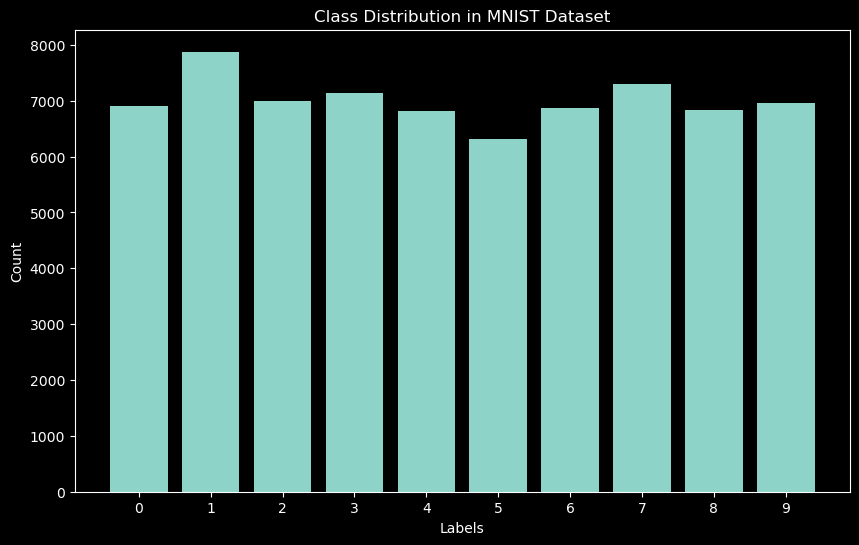

In [6]:
# Initialize a Counter object
label_count = Counter()

# Loop through the dataset to count the labels
for _, labels in train_loader:
    label_count.update(labels.numpy())

# Convert the Counter object to a dictionary for easier manipulation
label_count_dict = dict(label_count)

# Print the label distribution
print("Class Distribution:", label_count_dict)

labels = list(label_count_dict.keys())
counts = list(label_count_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Class Distribution in MNIST Dataset")
plt.xticks(labels)
plt.show()

After examining the class distribution of the MNIST dataset, it's evident that the classes are well-balanced. Each digit from 0 to 9 appears in roughly the same number of instances in the dataset. Therefore, we don't need to worry about class imbalance affecting our model's performance.

## Building the Discriminator Model

### Architecture

The Discriminator is a neural network that aims to classify whether a given image is real (from the dataset) or fake (generated by the Generator). In this enhanced model, we'll incorporate Convolutional Neural Network (CNN) layers to better capture the hierarchical features in images. The updated architecture will consist of the following layers:

1. **Convolutional Layer 1**: A 2D convolutional layer with 64 filters and a kernel size of 3x3, followed by a ReLU activation function.
2. **Convolutional Layer 2**: Another 2D convolutional layer with 128 filters and a kernel size of 3x3, followed by a ReLU activation function.
3. **Flatten**: A layer to flatten the output from the convolutional layers.
4. **Fully Connected Layers**: One hidden layer with 128 neurons, using a ReLU activation function.
5. **Output Layer**: A single neuron with a Sigmoid activation function to output the probability that the input image is real.

### Objective and Loss Function

The objective of the Discriminator is derived from a [minimax](https://en.wikipedia.org/wiki/Minimax) two-player game as defined in the original [GAN paper](https://arxiv.org/pdf/1406.2661.pdf). The value function $V(D, G)$ for this game is:

$$ 
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\log(1 - D(G(z)))] 
$$

This can be interpreted as maximizing the log-likelihood of correctly classifying both real and fake samples. In practical terms, this objective is implemented using binary cross-entropy loss, with the Discriminator aiming to output values close to 1 for real images and close to 0 for fake images.

### Implementation

The model will be implemented using PyTorch. Given the objective and the architecture, the Discriminator will be trained using real images labeled as 1 and fake images labeled as 0. The inclusion of convolutional layers aims to improve its ability to distinguish between real and fake images effectively.


In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_size):
        super(Discriminator, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Calculate the output dimension after conv and pooling layers
        self.calc_dim = lambda x: int(((x - 2) // 2 + 1) // 2)
        self.flat_dim = (
            128
            * self.calc_dim(self.calc_dim(img_size))
            * self.calc_dim(self.calc_dim(img_size))
        )

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = x.view(-1, self.flat_dim)  # flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # output between 0 and 1
        return x

## Building the Generator Model

### Architecture

The Generator is a neural network designed to create synthetic data that resembles a real dataset. For image generation tasks, it employs a series of Transposed Convolutional Neural Network (DeconvNet) layers that help upscale a lower-dimensional input to a full-sized image. The architecture consists of the following layers:

1. **Fully Connected Layer**: Takes a noise vector (e.g., 100-dimensional) as input and maps it to a higher-dimensional space (256 * 7 * 7), setting the stage for the transposed convolutions.
2. **Transposed Convolutional Layer 1**: A 2D transposed convolutional layer with 128 filters and a kernel size of 3x3. It is followed by a ReLU activation function.
3. **Transposed Convolutional Layer 2**: Another 2D transposed convolutional layer with 64 filters and a kernel size of 3x3, also followed by a ReLU activation function.
4. **Output Layer**: A final 2D transposed convolutional layer with a single filter, having a kernel size of 3x3, with a Tanh activation function to output an image in a range between -1 and 1.

### Objective and Loss Function

The objective of the Generator, in the context of a Generative Adversarial Network (GAN), is to generate data that is indistinguishable from real data by the Discriminator. Mathematically, the Generator aims to minimize the following function in a [minimax game](https://en.wikipedia.org/wiki/Minimax) against the Discriminator:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\log(1 - D(G(z)))]
$$

In simple terms, the Generator wants to maximize the error of the Discriminator in classifying its output as fake. The loss function generally used is the binary cross-entropy loss.

### Implementation

The Generator model is implemented using PyTorch. The architecture is built to transform random noise vectors into images that should ideally fool the Discriminator into thinking they are real. The sequence of transposed convolutional layers helps in this upscaling and feature refinement to generate high-quality images.


In [8]:
class Generator(nn.Module):
    def __init__(self, noise_size, out_channels, img_size):
        super(Generator, self).__init__()

        # Calculate dimensions to back out to the image size
        self.init_height = img_size // 4
        self.init_width = img_size // 4

        # Fully connected layer to reshape the input noise vector
        self.fc = nn.Linear(noise_size, 256 * self.init_height * self.init_width)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, out_channels, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(
            -1, 256, self.init_height, self.init_width
        )  # Reshape to (batch_size, num_channels, width, height)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # output between -1 and 1
        return x

## Trainig

In [9]:
def generate_fake_images(generator, noise_size, number_of_fake_samples=8):
    with torch.no_grad():
        # Create a batch of latent vectors (noise)
        z = torch.randn(number_of_fake_samples, noise_size).to(device)
        # Generate images from the latent vector z
        fake_images = generator(z)
        # Move the tensor from GPU to CPU and detach it from the computation graph
        fake_images = fake_images.cpu().detach()
        grid_images = torchvision.utils.make_grid(
            fake_images, nrow=8
        )  # Arrange the images into a grid with 8 columns
        # Use the adapted imshow function
        imshow(grid_images)

In [10]:
def add_instance_noise(images, std=0.01):
    return images + torch.randn_like(images) * std

def smooth_positive_labels(y):
    return y - 0.3 + (torch.rand(y.size()).to(device) * 0.3)  # 0.7 to 1.0

def smooth_negative_labels(y):
    return y + torch.rand(y.size()).to(device) * 0.3  # 0.0 to 0.3


def train_discriminator(
    discriminator, real_images, fake_images, criterion, optimizer_d, k, batch_size, do_smoothing=False, do_instance_noise=False
):
    for _ in range(k):
        # Discriminator training
        optimizer_d.zero_grad()

        if do_instance_noise:
            real_images = add_instance_noise(real_images)
            fake_images = add_instance_noise(fake_images)

        # Real images
        labels_real = torch.ones(real_images.size(0), 1).to(device)
        if do_smoothing:
            labels_real = smooth_positive_labels(labels_real)

        outputs_real = discriminator(real_images)

        loss_real = criterion(outputs_real, labels_real)

        labels_fake = torch.zeros(batch_size, 1).to(device)
        if do_smoothing:
            labels_fake = smooth_negative_labels(labels_fake)

        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, labels_fake)

        # Combine losses and update Discriminator
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

    return loss_d


def train_generator(discriminator, fake_images, criterion, optimizer_g, batch_size):
    # Generator training
    optimizer_g.zero_grad()

    outputs = discriminator(fake_images)
    labels = torch.ones(batch_size, 1).to(device)

    # Update Generator
    loss_g = criterion(outputs, labels)
    loss_g.backward()
    optimizer_g.step()
    return loss_g


def train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=False,
    do_instance_noise=False,
    log_samples=False,
    log_interval=10
):
    losses_d = []
    losses_g = []
    # Training loop
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            for _, (real_images, _) in enumerate(train_loader):
                # Move tensors to the device
                real_images = real_images.to(device)
                noise = torch.randn(batch_size, noise_size).to(device)
                fake_images = generator(noise).to(device)

                loss_d = train_discriminator(
                    discriminator,
                    real_images,
                    fake_images,
                    criterion,
                    optimizer_d,
                    k,
                    batch_size,
                    do_smoothing=do_smoothing_label,
                    do_instance_noise=do_instance_noise
                )
                loss_g = train_generator(
                    discriminator, fake_images, criterion, optimizer_g, batch_size
                )

            pbar.update(1)
            pbar.set_postfix(
                {"discriminator_loss": loss_d.item(), "generator_loss": loss_g.item()},
                refresh=True,
            )

            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

            if log_samples and epoch % log_interval == 0:
                generate_fake_images(generator, noise_size)

    return losses_d, losses_g

In [11]:
# Plot the losses
def plot_losses(losses_d, losses_g):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_d, label="Discriminator loss")
    plt.plot(losses_g, label="Generator loss")
    plt.legend()
    plt.title("Losses")
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]/home/k/anaconda3/envs/GANs/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  2%|▏         | 1/50 [00:09<07:31,  9.22s/it, discriminator_loss=1.03, generator_loss=1.18]

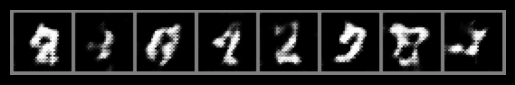

 22%|██▏       | 11/50 [01:40<05:53,  9.06s/it, discriminator_loss=1.17, generator_loss=1.01]

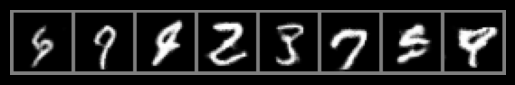

 42%|████▏     | 21/50 [03:09<04:19,  8.96s/it, discriminator_loss=1.2, generator_loss=1.33]  

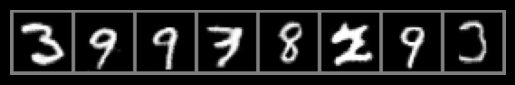

 62%|██████▏   | 31/50 [04:40<02:50,  8.97s/it, discriminator_loss=1.16, generator_loss=1.29] 

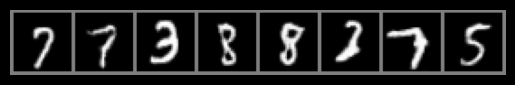

 82%|████████▏ | 41/50 [06:12<01:21,  9.08s/it, discriminator_loss=1.15, generator_loss=1.14] 

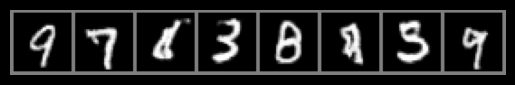

100%|██████████| 50/50 [07:33<00:00,  9.07s/it, discriminator_loss=1.2, generator_loss=0.986] 


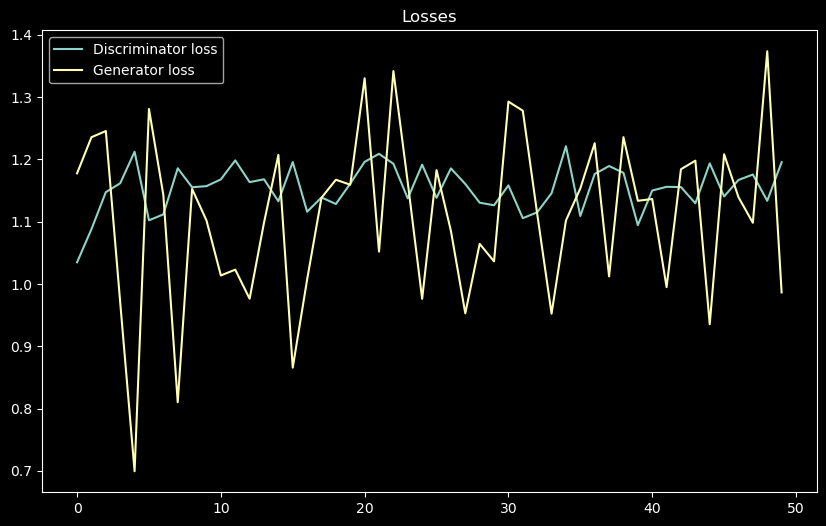

In [12]:
# Hyperparameters
learning_rate_d = 0.0001
learning_rate_g = 0.0001
batch_size = 64
epochs = 50
noise_size = 100  # Dimension of random noise vector for Generator
k = 2  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = Discriminator(1, img_size).to(device)
# Create the Generator model
generator = Generator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=10
)
plot_losses(losses_d, losses_g)

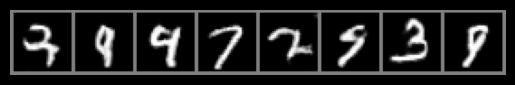

In [13]:
generate_fake_images(generator, noise_size)

## Evaluation

## Fashion MNIST

In [14]:
def get_fashion_data_loader(transform, batch_size=32):
    # Download and load the MNIST data
    train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    combined_data = torch.utils.data.ConcatDataset([train_data, test_data])
    # DataLoader allows us to batch and shuffle the data
    train_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader

  1%|          | 1/100 [00:09<15:02,  9.11s/it, discriminator_loss=0.984, generator_loss=1.33]

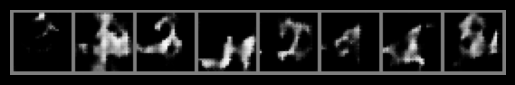

 11%|█         | 11/100 [01:40<13:29,  9.09s/it, discriminator_loss=1.12, generator_loss=1.11]

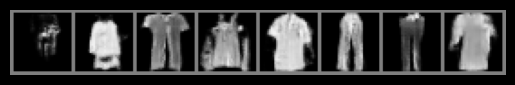

 21%|██        | 21/100 [03:10<11:55,  9.06s/it, discriminator_loss=1.11, generator_loss=1.1]  

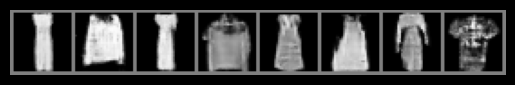

 31%|███       | 31/100 [04:41<10:27,  9.09s/it, discriminator_loss=1.13, generator_loss=1.15]

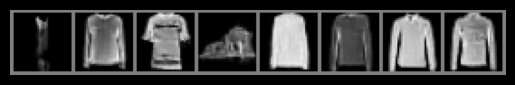

 41%|████      | 41/100 [06:13<09:06,  9.26s/it, discriminator_loss=1.13, generator_loss=1.12] 

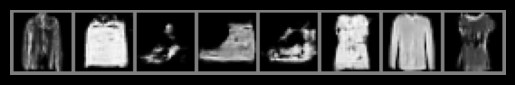

 51%|█████     | 51/100 [07:45<07:26,  9.12s/it, discriminator_loss=1.16, generator_loss=1.08]

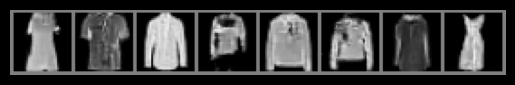

 61%|██████    | 61/100 [09:17<06:00,  9.25s/it, discriminator_loss=1.16, generator_loss=1.12] 

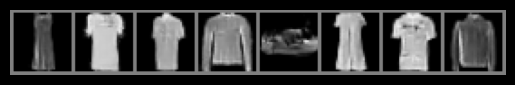

 71%|███████   | 71/100 [10:49<04:29,  9.29s/it, discriminator_loss=1.05, generator_loss=1.21]

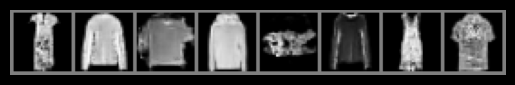

 81%|████████  | 81/100 [12:21<02:57,  9.33s/it, discriminator_loss=1.11, generator_loss=1.31]

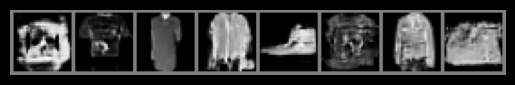

 91%|█████████ | 91/100 [13:53<01:23,  9.24s/it, discriminator_loss=1.16, generator_loss=1.27]

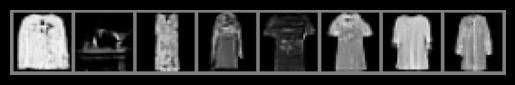

100%|██████████| 100/100 [15:16<00:00,  9.17s/it, discriminator_loss=1.07, generator_loss=1.42]


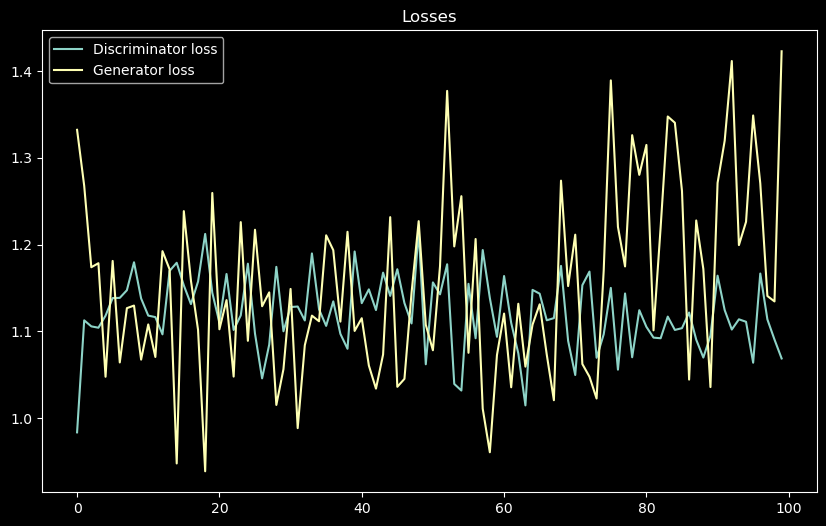

In [15]:
learning_rate_d = 0.0001
learning_rate_g = 0.0001
batch_size = 64
epochs = 100
noise_size = 100  # Dimension of random noise vector for Generator
k = 2  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = Discriminator(1, img_size).to(device)
# Create the Generator model
generator = Generator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_fashion_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=10
)
plot_losses(losses_d, losses_g)

## Other models

In [16]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.leaky_relu(x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(ConvLayer(in_channels + i * growth_rate, growth_rate))

    def forward(self, x):
        outputs = [x]
        for layer in self.layers:
            out = layer(torch.cat(outputs, dim=1))
            outputs.append(out)
        return torch.cat(outputs, dim=1)


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = ConvLayer(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class DenseNetDiscriminator(nn.Module):
    def __init__(self, in_channels, img_size):
        super(DenseNetDiscriminator, self).__init__()
        self.input_size = img_size
        self.init_conv = ConvLayer(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.dense1 = DenseBlock(64, 32, 4)
        self.trans1 = TransitionLayer(192, 96)  # 64 + 4 * 32 = 192 | 192 / 2 = 96
        self.dense2 = DenseBlock(96, 32, 4)
        self.trans2 = TransitionLayer(224, 112)  # 96 + 4 * 32 = 224 | 224 / 2 = 112
        self.dense3 = DenseBlock(112, 32, 4)
        self.trans3 = TransitionLayer(240, 120)  # 112 + 4 * 32 = 240 | 240 / 2 = 120
        self.dense4 = DenseBlock(120, 32, 4)

        self.fc = nn.Linear(248, 512)  # 120 + 4 * 32 = 248
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.pool(x)

        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

In [17]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer in the residual block
        # Followed by Batch Normalization
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer in the residual block
        # Followed by Batch Normalization
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # Forward pass
        out = F.leaky_relu(self.bn1(self.conv1(x)))  # First Conv -> BN -> ReLU
        out = self.bn2(self.conv2(out))  # Second Conv -> BN
        out += self.shortcut(x)  # Add the shortcut
        out = F.leaky_relu(out)  # Final ReLU
        return out


class ResidualGenerator(nn.Module):
    def __init__(self, noise_size, out_channels, img_size):
        super(ResidualGenerator, self).__init__()

        # Calculate dimensions to back out to the image size
        self.init_height = img_size // 4
        self.init_width = img_size // 4

        # Fully connected layer to reshape the input noise vector
        self.fc = nn.Linear(noise_size, 256 * self.init_height * self.init_width)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.bn1 = nn.BatchNorm2d(128)

        # Add a Residual Block
        self.res_block = ResidualBlock(128, 128)

        # Add Dropout
        self.dropout = nn.Dropout(0.5)

        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(
            64, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.fc(x)
        
        x = x.view(
            -1, 256, self.init_height, self.init_width
        )  # Reshape to (batch_size, num_channels, width, height)

        x = self.deconv1(x)
        x = self.bn1(x)  # BatchNorm
        x = F.leaky_relu(x)

        x = self.res_block(x)  # Using Residual Block
        x = self.dropout(x)  # Applying Dropout

        x = self.deconv2(x)
        x = self.bn2(x)  # BatchNorm
        x = F.leaky_relu(x)

        x = self.deconv3(x)
        x = self.bn3(x)

        x = torch.tanh(x)  # output between -1 and 1
        return x

  2%|▏         | 1/50 [00:25<20:25, 25.01s/it, discriminator_loss=0.824, generator_loss=1.86]

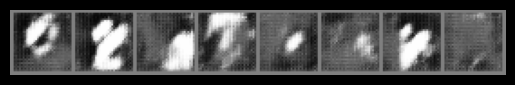

 10%|█         | 5/50 [02:04<18:46, 25.04s/it, discriminator_loss=0.857, generator_loss=1.88]

In [26]:
# Hyperparameters
learning_rate_d = 0.0001
learning_rate_g = 0.0001
batch_size = 64
epochs = 50
noise_size = 100  # Dimension of random noise vector for Generator
k = 2  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = DenseNetDiscriminator(1, img_size).to(device)
# Create the Generator model
generator = ResidualGenerator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_fashion_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=10
)
plot_losses(losses_d, losses_g)

In [ ]:
generate_fake_images(generator, noise_size)

## DOGs

In [21]:
def get_dogs_data_loader_for_class(transform, batch_size=32):
    dataset_path = "data/stanford-dogs-dataset"  # Adjust this to your actual path
    dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "images"), transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 1/200 [00:44<2:26:06, 44.05s/it, discriminator_loss=1.39, generator_loss=0.719]

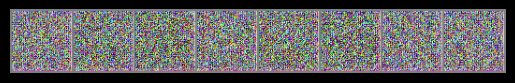

  0%|          | 1/200 [01:25<4:44:07, 85.66s/it, discriminator_loss=1.39, generator_loss=0.719]


KeyboardInterrupt: 

In [24]:
# Hyperparameters
learning_rate_d = 0.001
learning_rate_g = 0.0001
batch_size = 512
epochs = 200
noise_size = 100  # Dimension of random noise vector for Generator
k = 1  # Number of steps to apply to the Discriminator
channels = 3  # Number of channels in the image
img_size = 64  # Size of the image

# Create the Discriminator model
discriminator = DenseNetDiscriminator(channels, img_size).to(device)
# Create the Generator model
generator = ResidualGenerator(noise_size, channels, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.SGD(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader + data augmentation
transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.Pad(int(img_size * 0.1), padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(10, fill=(0,)),
        transforms.CenterCrop(img_size),  # crop back to original size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_loader = get_dogs_data_loader_for_class(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=10
)
plot_losses(losses_d, losses_g)

## Conclusion

### Equilibrium
... Nash